# HW6 GAN

Modification needed to achieve Medium baseline:

- Model

- Training

# Dataset/Dataloader

## Dataset

1. Resize images to (64, 64).
2. Linearly map values from [0, 1] to [-1, 1].

In [1]:
import os
import glob
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset


class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.n_samples = len(self.fnames)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        # load image
        img = torchvision.io.read_image(fname)
        # image transform
        img = self.transform(img)
        return img
    
    def __len__(self):
        return self.n_samples
    
def get_dataset(root):
    # get paths of images
    fnames = glob.glob(os.path.join(root, "*"))
    compose = [
        v2.ToPILImage(),
        # 1. Resize image to (64, 64)
        v2.Resize((64, 64)),
        # map values to [0, 1]
        v2.ToTensor(),
        # 2. Linearly map values to [-1, 1]
        v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]
    transform = v2.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset


/Users/complexa/anaconda3/envs/complexa_ML21_3a/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/complexa/anaconda3/envs/complexa_ML21_3a/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to use

### Show Some Images

In [ ]:
import matplotlib.pyplot as plt

dataset = get_dataset("./data/faces")

print("values in [-1, 1]:")
images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1,2,0))
plt.show()

print("values in [0, 1]:")
images_origin = [(dataset[i]+1)/2 for i in range(16)]
grid_img_origin = torchvision.utils.make_grid(images_origin, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img_origin.permute(1,2,0))
plt.show()

## Dataloader

In [2]:
from torch.utils.data import DataLoader


def get_dataloader(dataset, batch_size, n_workers):
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )
    return dataloader

# Model

`N` of the input/output shape stands for batch size.

In [8]:
import torch.nn as nn

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0.0)

class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super().__init__()

        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU()
            )
        
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y
    

class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super().__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2)
            )
        
        """ Medium: Remove Sigmoid Layer for WGAN. """        
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2),
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            nn.Sigmoid() 
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

# Training

## Tools Kit

Common tools kit.

### Seed

Fix random seed for reproduction.

In [4]:
import random
import torch
import numpy as np


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

### Device

Get running device.

In [5]:
import torch


def get_device():
    return "cuda" if torch.cuda.is_available() \
      else "mps" if torch.backends.mps.is_available() \
      else "cpu"

### Load/Save Checkpoint

Class that handles loading/saving checkpoint.

In [6]:
import torch

class ModelSaveLoad:
    def __init__(self, save_path, load_path):
        self.save_path = save_path
        self.load_path = load_path

    def save(self, modelG_state_dict, modelD_state_dict):
        torch.save({
            "modelG_state_dict" : modelG_state_dict,
            "modelD_state_dict" : modelD_state_dict,
        }, self.save_path)

    def load(self):
        """Return checkpoint."""
        return torch.load(self.load_path)

## Main

## Training Loop

In [ ]:
def train():
    ...

## Main Function

   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:12:44<00:00:00  1.46it/s  0.2749  2.2056    1    1115            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_001.jpg.


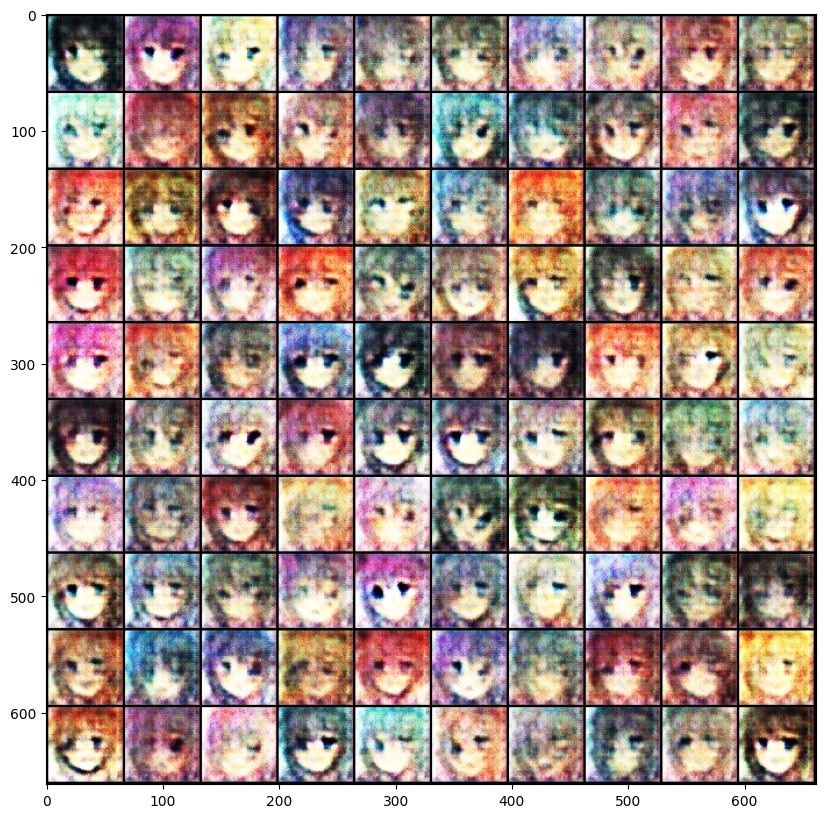

In [15]:
import os
import torch
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm


""" Medium: n_epoch = 50, n_critic = 5, clip_value = 0.01 """
def parse_args():
    config = {
        "seed": 1,
        "batch_size": 64,
        "z_dim": 100,
        "n_workers": 0,
        "n_epoch": 1,
        "n_critic": 1,
        #"clip_value": 0.01,
        "lr": 1e-4,
        "onColab": False,
        "load_ckpt": False,
        "workspace_dir_config": {
            "local": "./",
            "drive" : "/content/drive/MyDrive/ML2021_data/hw6/"
        },
    }
    return config

def main(
        seed,
        batch_size,
        z_dim,
        n_workers,
        n_epoch,
        n_critic,
        #clip_value,
        lr,
        workspace_dir_config,
        onColab,
        load_ckpt
):
    device = get_device()

    if onColab:
        workspace_dir = workspace_dir_config['drive']
    else:
        workspace_dir = workspace_dir_config['local']

    log_dir = os.path.join(workspace_dir, "logs")
    ckpt_dir = os.path.join(workspace_dir, "checkpoints")
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(ckpt_dir, exist_ok=True)

    ckpt_path = os.path.join(ckpt_dir, "model.ckpt")
    modelSL = ModelSaveLoad(ckpt_path, ckpt_path)

    # dataset/dataloader
    data_dir = os.path.join(workspace_dir, "data/faces")
    dataset = get_dataset(data_dir)
    dataloader = get_dataloader(dataset, batch_size, n_workers)

    # model
    modelG = Generator(in_dim=z_dim)
    modelD = Discriminator(3)
    if load_ckpt:
        checkpoint = modelSL.load()
        modelG.load_state_dict(checkpoint['modelG_state_dict'])
        modelD.load_state_dict(checkpoint['modelD_state_dict'])
    modelG.to(device)
    modelD.to(device)

    # loss
    criterion = nn.BCELoss()

    # optimizer
    optG = torch.optim.Adam(modelG.parameters(), lr=lr, betas=(0.5, 0.999))
    optD = torch.optim.Adam(modelD.parameters(), lr=lr, betas=(0.5, 0.999))
    """ Medium: Use RMSprop for WGAN. """
    #optG = torch.optim.RMSprop(modelG.parameters(), lr=lr)
    #optD = torch.optim.RMSprop(modelD.parameters(), lr=lr)

    # distribution samples for generator to produce images
    z_sample = torch.randn((100, z_dim)).to(device)
    
    # training
    modelG.train()
    modelD.train()
    for e, epoch in enumerate(range(n_epoch)):
        progress_bar = qqdm(dataloader)
        for i, data in enumerate(progress_bar):
            imgs = data.to(device)

            # batch size of imgs
            bs = imgs.size(0)
            
            # ============================================
            # Train Discriminator
            # ============================================
            z = torch.randn(bs, z_dim).to(device)
            r_imgs = imgs
            f_imgs = modelG(z)

            """ Medium: Use WGAN Loss. """
            # label
            r_label = torch.ones((bs)).to(device)
            f_label = torch.zeros((bs)).to(device)

            # model forwarding
            r_logits = modelD(r_imgs)
            f_logits = modelD(f_imgs)

            # compute the loss for the discriminator
            r_loss = criterion(r_logits, r_label)
            f_loss = criterion(f_logits, f_label)
            loss_D = (r_loss + f_loss) / 2
            # WGAN Loss
            #loss_D = -torch.mean(modelD(r_imgs)) + torch.mean(modelD(f_imgs))

            # model backward
            modelD.zero_grad()
            loss_D.backward()

            # update discriminator
            optD.step()

            """ Medium: Clip weights of Discriminator. """
            #for p in modelD.parameters():
            #    p.data.clamp_(-clip_value, clip_value)
            
            # ============================================
            # Train Generator
            # ============================================
            # Viewing Generator + Discriminator as a compund model.
            if i % n_critic == 0:
                # generate some fake images
                z = torch.randn((bs, z_dim)).to(device)
                f_imgs = modelG(z)

                # Discriminator score images from Generator
                f_logits = modelD(f_imgs)

                """ Mediun: Use WGAN Loss. """
                # compute the loss for the generator (infact is the loss of generator + discriminator)
                loss_G = criterion(f_logits, r_label)
                # WGAN Loss
                #loss_G = -torch.mean(modelD(f_imgs))

                # model backward
                modelG.zero_grad()
                loss_G.backward()

                # update generator
                optG.step()
        
            # set info for the progress bar
            #   Note that the value of GAN loss is not directly related to
            #   the quality of the generated images.
            progress_bar.set_infos({
                'Loss_D' : round(loss_D.item(), 4),
                'Loss_G' : round(loss_G.item(), 4),
                'Epoch' : e+1,
                'Step' : i+1
            })

        modelG.eval()
        f_imgs_sample = (modelG(z_sample).data + 1) / 2.0
        filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
        torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
        print(f' | Save some samples to {filename}.')

        # show generated images in jupyter notebook
        grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.show()
        modelG.train()

        if (e+1) % 5 == 0 or e == 0:
            # save checkpoints
            modelSL.save(modelG_state_dict=modelG.state_dict(), modelD_state_dict=modelD.state_dict())


if __name__ == "__main__":
    main(**parse_args())

# Inference

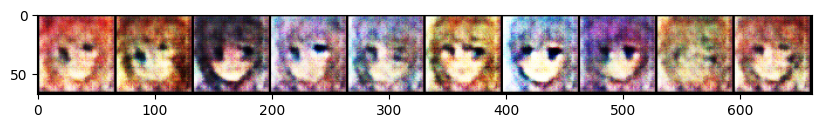

In [17]:
import os
import matplotlib.pyplot as plt


def parse_args():
    config = {
        "n_imgs": 100,
        "z_dim": 100,
        "onColab": False,
        "workspace_dir_config": {
            "local": "./",
            "drive" : "/content/drive/MyDrive/ML2021/hw6/"
        }
    }
    return config

def main(
        n_imgs,
        z_dim,
        onColab,
        workspace_dir_config
):
    device = get_device()

    if onColab:
        workspace_dir = workspace_dir_config['drive']
    else:
        workspace_dir = workspace_dir_config['local']

    ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
    checkpoint = torch.load(os.path.join(ckpt_dir, 'model.ckpt'))
    G = Generator(z_dim)
    G.load_state_dict(checkpoint['modelG_state_dict'])
    G.to(device)
    G.eval()

    # generate n_imgs images and make a grid to save them
    z_sample = torch.randn((n_imgs, z_dim)).to(device)
    imgs_sample = (G(z_sample).data + 1) / 2.0
    log_dir = os.path.join(workspace_dir, 'logs')
    filename = os.path.join(log_dir, 'result.jpg')
    torchvision.utils.save_image(imgs_sample, filename, nrow=10)

    # show some images
    n_display = min(int(n_imgs / 10), 32)
    grid_img = torchvision.utils.make_grid(imgs_sample[:n_display].cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()


if __name__ == '__main__':
    main(**parse_args())
